# Base model

1. write a cost function to calculate the total cost
2. for each day, find 125 top choices from users
3. from 125 to 300 available spots, based on people's top choices, we allocate those spots to people


# Explore the dataset

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
!ls

base_model_v0.ipynb         sample_submission_santa.csv
family_data.csv


In [3]:
os.getcwd()

'/Users/rachel/github_repos/competitions/santasworkshoptour2019'

In [4]:
os.listdir(os.getcwd()) 

['base_model_v0.ipynb',
 'sample_submission_santa.csv',
 'family_data.csv',
 '.ipynb_checkpoints']

In [5]:
df = pd.read_csv('family_data.csv',index_col='family_id') #import family dataset
print(df.head(10))
print(df.shape)
print(df['n_people'].sum())

           choice_0  choice_1  choice_2  choice_3  choice_4  choice_5  \
family_id                                                               
0                52        38        12        82        33        75   
1                26         4        82         5        11        47   
2               100        54        25        12        27        82   
3                 2        95         1        96        32         6   
4                53         1        47        93        26         3   
5                32        59        12         3        60        26   
6                88         4         1         3        91        32   
7                25        11        52        48        10        17   
8                18        60         1        12        89        33   
9                 1        88        39        50        26        18   

           choice_6  choice_7  choice_8  choice_9  n_people  
family_id                                                    

In [12]:
df_submit = pd.read_csv('sample_submission_santa.csv',index_col='family_id') #import santa data
df_submit.iloc[10,0]

90

In [9]:
# daily count limit
# say if santa picks choice 0 as his choice, lets see how many invalid days we have
def invalid_days(df):
    for i in range(10):
        dict_counter = Counter(df[f'choice_{i}'])
        print(f'No. of days have between 125 and 300 people when choose choice {i}',len([v for v in dict_counter.values() if v > 125 and v < 300]))
        
invalid_days(df)  
# basically, we can not just choose one single choice, we need to mix and match


No. of days have between 125 and 300 people when choose choice 0 0
No. of days have between 125 and 300 people when choose choice 1 0
No. of days have between 125 and 300 people when choose choice 2 0
No. of days have between 125 and 300 people when choose choice 3 0
No. of days have between 125 and 300 people when choose choice 4 1
No. of days have between 125 and 300 people when choose choice 5 1
No. of days have between 125 and 300 people when choose choice 6 1
No. of days have between 125 and 300 people when choose choice 7 1
No. of days have between 125 and 300 people when choose choice 8 1
No. of days have between 125 and 300 people when choose choice 9 1


# Create cost function to calculate total cost

In [14]:
cols = [f'choice_{i}' for i in range(10)]
choice_dict = df[cols].to_dict()
family_dict = df['n_people'].to_dict()
min_count = 125
max_count = 300
preference_cost = {} 
penalty = 0 

a_p_dict = {}
i_y_list = []

# from 100 to 1
days = list(range(100,0,-1))


#best is a dataframe with family index and allocation

def cost_function(best):
    
    penalty = 0
    
    # test validity
    dict_counter = Counter(list(best.iloc[:,0]))  
    list_day_counts = dict_counter.values()

    for x in list_day_counts:
        if x < 125 or x > 300:
            penalty += 1000000000
       
    
    # cost
    for f in best.index:
        
        if best.iloc[f,0] == choice_dict['choice_0'][f]:
            preference_cost[f] = 0
        if best.iloc[f,0] == choice_dict['choice_1'][f]:
            preference_cost[f] = 50*family_dict[f]
        if best.iloc[f,0] == choice_dict['choice_2'][f]:
            preference_cost[f] = 50+9 * family_dict[f]
        if best.iloc[f,0] == choice_dict['choice_3'][f]:
            preference_cost[f] = 100 + 9 * family_dict[f]
        if best.iloc[f,0] == choice_dict['choice_4'][f]:
            preference_cost[f] = 200 + 9 * family_dict[f]
        if best.iloc[f,0] == choice_dict['choice_5'][f]:
            preference_cost[f] = 200 + 18 * family_dict[f]
        if best.iloc[f,0] == choice_dict['choice_6'][f]:
            preference_cost[f] = 300 + 18 * family_dict[f]
        if best.iloc[f,0] == choice_dict['choice_7'][f]:
            preference_cost[f] = 300 + 36 * family_dict[f]
        if best.iloc[f,0] == choice_dict['choice_8'][f]:
            preference_cost[f] = 400 + 36 * family_dict[f]
        if best.iloc[f,0] == choice_dict['choice_9'][f]:
            preference_cost[f] = 500 + (36 + 199) * family_dict[f]
        else:
            preference_cost[f] = 500 + (36 + 398) * family_dict[f]
            
    penalty += sum(preference_cost.values())  # sum all accounting costx
    
    
    # accounting cost
    for d in dict_counter.keys():
        if not i_y_list: 
            diff = 0
            a_p = (dict_counter[d]-125)/400*dict_counter[d]**(0.5 + diff / 50.0)
            i_y_list.append(dict_counter[d])
            a_p_dict[d] = a_p
            #print('first time')

        else:
            a_p = (dict_counter[d]-125)/400*dict_counter[d]**(0.5 + abs(dict_counter[d]-i_y_list[-1])/ 50.0)
            i_y_list.append(dict_counter[d])
            a_p_dict[d] = a_p
            #print('not first time')
            
    # final cost
    penalty += sum(a_p_dict.values())

    return penalty

In [15]:
cost_function(df_submit)

100011570792.41748

# Instead of bruteforce through all the possible answers, we know that everyday we need to have at least 125 attendies. We can start allocating by day, pick the top 125 families with best choices (lower preference cost)

Construct a cost function for total cost
1. choice cost for all choices
2. constraints function which is if evaluate if on a day if the total compacity has been surpassed >= 125 and <= 300
3. Accounting cost based on the choices made
4. optimization should be in order based on the choice of the users, rather than bruteforce:
    for example:starting from the day 100, find the person who chose 100 as their top preference first, then increase the number until 125, then construct to next day. At this time the accounting cost is zero
    Then we will allocate the rest of the people who did not choose
    
    the starting point should be each day, pick the most popular 125 choice 0, 1, 2...9 from most people to least people

In [ ]:
#each day, first 125 people's choice
choice_dict = df

def cost_function_first_125(choice_dict):
    
    for d in range(100,0,-1):
        



In [99]:
#df_unindexed.set_index(['Fruit', 'Color'])


# testdf = df.copy()
# #print(testdf.head(1))
# testdf = testdf.reset_index()
# #print(testdf.head())
# testdf = testdf.set_index(['family_id','n_people'])
# testdf_dict = testdf.to_dict()
# d = 100
# i = 0
# testdf_dict_2 = {k:v for (k,v) in testdf_dict[f'choice_{i}'].items() if v == d}
# l = list(testdf_dict_2.keys())
# print(l)
# print(l[0][1])
# print([l[x][1] for x in range(len(l))])

# print([l[x][0] for x in range(len(l))])


# rank the 2nd element in a list and rank the second element from highest to lowest
# 100,choice0, n people, highest to lowest, 99, choice 1, n people highest to lowest



#xcreate dataframe:

# df_reshaped = pd.DataFrame()

# df_reshaped['n_people'] = [l[x][0] for x in range(len(l))]
# df_reshaped['family_id'] = [l[x][0] for x in range(len(l))]
# df_reshaped['choice']   list(testdf_dict_2.keys())]


testdf = df.copy()
testdf = testdf.reset_index()
#print(testdf.head(10))
long_df = pd.wide_to_long(testdf, stubnames='choice_', i=['family_id', 'n_people'], j='choice_order')
long_df_resetindex = long_df.reset_index()
long_df_resetindex.rename(columns={"choice_": "chosen_day", "choice_order": "choice_preference"},inplace = True)

In [167]:
#print(long_df_resetindex.head(10))

choice_preference_list = range(10)
chosen_day_list = range(100,0,-1)

#print(choice_preference_list,chosen_day_list)


submission_df = pd.DataFrame()

daily_count = {}


for d in chosen_day_list:    
    temp_df = long_df_resetindex.loc[long_df_resetindex['chosen_day']==d,:].sort_values(by = 'n_people',ascending =False)    
   
    #starting day of each day with 0 people
    daily_count[d] = 0
    
    for ch in choice_preference_list:
        temp_df_pref = temp_df.loc[temp_df['choice_preference'] == ch].reset_index()
        for ind in temp_df_pref.index:
            if temp_df_pref.iloc[ind]['n_people'] + daily_count[d] <= 125:
                                 
                daily_count[d]+= temp_df_pref.iloc[ind]['n_people']
                submission_df = submission_df.append(temp_df_pref.iloc[ind])



    choice_preference  chosen_day  family_id    index  n_people
0                 0.0       100.0     3570.0  35700.0       7.0
1                 0.0       100.0      793.0   7930.0       6.0
2                 0.0       100.0     4629.0  46290.0       6.0
3                 0.0       100.0     1468.0  14680.0       4.0
4                 0.0       100.0     1794.0  17940.0       4.0
5                 0.0       100.0     1433.0  14330.0       3.0
6                 0.0       100.0        2.0     20.0       3.0
7                 0.0       100.0     2340.0  23400.0       3.0
8                 0.0       100.0     2881.0  28810.0       3.0
9                 0.0       100.0      155.0   1550.0       2.0
10                0.0       100.0     1111.0  11110.0       2.0
0                 1.0       100.0     3161.0  31611.0       7.0
1                 1.0       100.0     1940.0  19401.0       6.0
2                 1.0       100.0      196.0   1961.0       6.0
3                 1.0       100.0     26

In [171]:
print(submission_df.tail(50))

    choice_preference  chosen_day  family_id    index  n_people
7                 0.0         3.0     1416.0  14160.0       7.0
8                 0.0         3.0     2494.0  24940.0       7.0
9                 0.0         3.0     3528.0  35280.0       7.0
10                0.0         3.0     4740.0  47400.0       7.0
11                0.0         3.0      237.0   2370.0       7.0
12                0.0         3.0     3720.0  37200.0       6.0
13                0.0         3.0     1940.0  19400.0       6.0
14                0.0         3.0     1726.0  17260.0       6.0
15                0.0         3.0     2471.0  24710.0       6.0
16                0.0         3.0      151.0   1510.0       6.0
17                0.0         3.0      159.0   1590.0       6.0
0                 0.0         2.0     2519.0  25190.0       8.0
1                 0.0         2.0      127.0   1270.0       8.0
2                 0.0         2.0     1397.0  13970.0       7.0
3                 0.0         2.0     29

In [141]:
long_df_resetindex_100 = long_df_resetindex.loc[long_df_resetindex['chosen_day']==100,:].reset_index()
long_df_resetindex_100.iloc[1]
#empty = pd.DataFrame()
empty = empty.append(long_df_resetindex_100.iloc[1])
print(empty)

   choice_preference  chosen_day  family_id  index  n_people
0                0.0       100.0        2.0   20.0       3.0
0                0.0       100.0        2.0   20.0       3.0
1                9.0       100.0       19.0  199.0       2.0


In [143]:
long_df_resetindex_100.iloc[1]['n_people']

2

In [98]:
long_df_resetindex_100_sorted = long_df_resetindex_100.sort_values(by = 'choice_preference')

for i in range(10):
    long_df_resetindex_100_prefer = long_df_resetindex_100.loc[long_df_resetindex_100['choice_preference'] == i]
    print(long_df_resetindex_100_prefer)

    
# find each day, then find choice preference from 0 to 9, order by n people highest to lowest
# then accumulate the count of people, stop until the number exceeds the 125
    

Empty DataFrame
Columns: [family_id, n_people, choice_preference, chosen_day]
Index: []
Empty DataFrame
Columns: [family_id, n_people, choice_preference, chosen_day]
Index: []
Empty DataFrame
Columns: [family_id, n_people, choice_preference, chosen_day]
Index: []
Empty DataFrame
Columns: [family_id, n_people, choice_preference, chosen_day]
Index: []
Empty DataFrame
Columns: [family_id, n_people, choice_preference, chosen_day]
Index: []
Empty DataFrame
Columns: [family_id, n_people, choice_preference, chosen_day]
Index: []
Empty DataFrame
Columns: [family_id, n_people, choice_preference, chosen_day]
Index: []
Empty DataFrame
Columns: [family_id, n_people, choice_preference, chosen_day]
Index: []
Empty DataFrame
Columns: [family_id, n_people, choice_preference, chosen_day]
Index: []
       family_id  n_people  choice_preference  chosen_day
9              0         4                  9          28
19             1         4                  9          61
29             2         3        

In [27]:
#want to have

#day,family, peoplecount
cols = [f'choice_{i}' for i in range(10)]
choice_dict = df[cols].to_dict()
#print(choice_dict)
# find number of people 


for d in range(100,1,-1):
    for i in range(10):
        d_temp = {k:v for (k,v) in choice_dict[f'choice_{i}'].items() if v == d}
        
    



{2: 100, 155: 100, 793: 100, 1111: 100, 1433: 100, 1468: 100, 1794: 100, 2340: 100, 2881: 100, 3570: 100, 4629: 100}


In [7]:
df_submission = pd.read_csv('sample_submission_santa.csv',index_col='family_id')
print(df_submission.head(3))

           assigned_day
family_id              
0                   100
1                    99
2                    98


It does not matter which family chose which day, what matters is the order (choice 0, 1,2,3,...)
also each day we need to have enough people, so we should accumulate people for each day

For example, for day 100, we will order from choice 0 to choice 9, from the largest family with each choice to the smallest family with each choice.until we reach the 300 limit, we will stop

In [180]:
n_daily_threshold = 0 #number of people in each day

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125
# from 100 to 1
# days = list(range(N_DAYS,0,-1))

In [181]:
#find a good way to count (TO CONTINUE FROM HERE 12/06)

df2 = df.copy()
day = 100

for i in range(10):
    subdf2 = df2[[f'choice_{i}','n_people']]
    subdf2_day = subdf2.loc[subdf2[f'choice_{i}'] == day,:]

    subdf2_day_sorted = subdf2_day.sort_values(['n_people'],ascending = False)


    for c in subdf2_day_sorted['n_people']:
        if n_daily_threshold + c <= 300:
            n_daily_threshold+=c
            #print(n_daily_threshold)

    print(i,n_daily_threshold)



0 43
1 84
2 146
3 192
4 276
5 298
6 300
7 300
8 300
9 300


In [41]:
#check the choices people made
for i in range(9):
    print(i,df[f'choice_{i}'].max(),df[f'choice_{i}'].min(),df[f'choice_{i}'].mode())

0 100 1 0    1
dtype: int64
1 100 1 0    1
dtype: int64
2 100 1 0    1
dtype: int64
3 100 1 0    1
dtype: int64
4 100 1 0    1
dtype: int64
5 100 1 0    1
dtype: int64
6 100 1 0    1
dtype: int64
7 100 1 0    1
dtype: int64
8 100 1 0    1
dtype: int64


In [42]:
# distribution of each choice (function)


In [37]:
df_submission = pd.read_csv('sample_submission_santa.csv',index_col='family_id')

In [38]:
print(df_submission.head(10))

           assigned_day
family_id              
0                   100
1                    99
2                    98
3                    97
4                    96
5                    95
6                    94
7                    93
8                    92
9                    91


In [39]:
print(df_submission.tail(10))

           assigned_day
family_id              
4990                 10
4991                  9
4992                  8
4993                  7
4994                  6
4995                  5
4996                  4
4997                  3
4998                  2
4999                  1


## overall strategy for the optimisation

In [35]:
# choice 0 will occur least amnount of the cost for santa (no consolation)
# but choice 0 might result some level of the penalty as we have the constraints of each day we can not have more than 300 and less than 125 participants
# create a function that evaluate the final cost of the strategy
# say we take all the choice 0 as what they are, we want to calculate total penalty scores and total cost, this time total cost is zero
# then we will tweak the function, minimise the penalty score 


## Set up constraints

In [63]:
family_size_dict = df[['n_people']].to_dict()['n_people']


cols = [f'choice_{i}' for i in range(10)]
print(cols)

choice_dict = df[cols].to_dict()
print(choice_dict.keys())

['choice_0', 'choice_1', 'choice_2', 'choice_3', 'choice_4', 'choice_5', 'choice_6', 'choice_7', 'choice_8', 'choice_9']
dict_keys(['choice_0', 'choice_1', 'choice_2', 'choice_3', 'choice_4', 'choice_5', 'choice_6', 'choice_7', 'choice_8', 'choice_9'])


In [59]:
N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(100,0,-1))

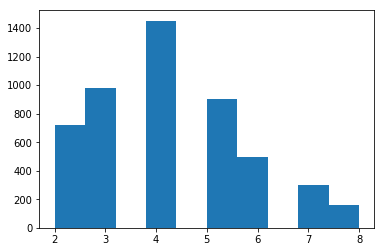

In [76]:
plt.hist(family_size_dict.values())
plt.show()

In [78]:
from collections import Counter
Counter(family_size_dict.values())

Counter({2: 717, 3: 981, 4: 1451, 5: 899, 6: 494, 7: 301, 8: 157})

In [79]:
# find all 2 people families's choice_0

df2 = df.copy()

In [81]:
df2_2people_choice0 = df2.loc[df2['n_people'] == 2, 'choice_0']

In [83]:
Counter(df2_2people_choice0)

Counter({1: 64,
         2: 7,
         3: 15,
         4: 14,
         5: 10,
         6: 2,
         7: 4,
         8: 4,
         9: 7,
         10: 10,
         11: 11,
         12: 13,
         13: 1,
         14: 9,
         15: 4,
         16: 8,
         17: 17,
         18: 10,
         19: 12,
         20: 9,
         21: 6,
         22: 5,
         23: 2,
         24: 3,
         25: 13,
         26: 12,
         27: 9,
         28: 6,
         29: 5,
         30: 5,
         31: 9,
         32: 13,
         33: 14,
         34: 2,
         35: 6,
         36: 5,
         37: 5,
         38: 11,
         39: 10,
         40: 12,
         41: 4,
         43: 7,
         44: 5,
         45: 17,
         46: 11,
         47: 15,
         48: 2,
         49: 6,
         50: 1,
         51: 3,
         52: 11,
         53: 5,
         54: 9,
         55: 2,
         56: 3,
         57: 4,
         58: 3,
         59: 16,
         60: 10,
         61: 9,
         63: 4,
         6

In [89]:
list(family_size_dict.keys())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


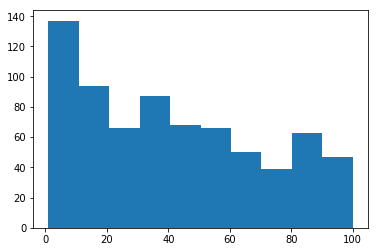

In [86]:
plt.hist(df2_2people_choice0)
plt.show()

In [90]:
for i in list(family_size_dict.keys()):
    df2_2people_choice0 = df2.loc[df2['n_people'] == i, 'choice_0']
    print(Counter(df2_2people_choice0))
#     plt.hist(df2_2people_choice0)
#     plt.show()

Counter()
Counter()
Counter({1: 64, 45: 17, 17: 17, 59: 16, 3: 15, 47: 15, 81: 15, 88: 14, 33: 14, 82: 14, 4: 14, 25: 13, 94: 13, 12: 13, 66: 13, 32: 13, 40: 12, 26: 12, 19: 12, 96: 12, 11: 11, 80: 11, 38: 11, 52: 11, 46: 11, 18: 10, 60: 10, 10: 10, 5: 10, 39: 10, 54: 9, 61: 9, 27: 9, 14: 9, 20: 9, 67: 9, 31: 9, 68: 8, 16: 8, 2: 7, 43: 7, 9: 7, 74: 7, 49: 6, 28: 6, 75: 6, 35: 6, 73: 6, 99: 6, 87: 6, 21: 6, 22: 5, 53: 5, 95: 5, 36: 5, 30: 5, 83: 5, 29: 5, 37: 5, 44: 5, 15: 4, 57: 4, 63: 4, 8: 4, 41: 4, 7: 4, 89: 4, 58: 3, 76: 3, 51: 3, 56: 3, 65: 3, 78: 3, 97: 3, 24: 3, 93: 3, 23: 2, 85: 2, 100: 2, 34: 2, 91: 2, 72: 2, 84: 2, 48: 2, 6: 2, 55: 2, 70: 2, 50: 1, 79: 1, 64: 1, 69: 1, 13: 1, 92: 1, 90: 1})
Counter({1: 59, 10: 23, 11: 23, 26: 22, 54: 21, 25: 21, 46: 20, 87: 20, 68: 19, 47: 19, 17: 19, 59: 19, 5: 18, 12: 18, 18: 18, 19: 17, 33: 17, 96: 17, 75: 16, 60: 16, 3: 15, 38: 15, 24: 14, 32: 14, 31: 14, 89: 14, 53: 14, 40: 14, 39: 13, 44: 13, 61: 13, 74: 12, 15: 12, 66: 12, 52: 12, 82: 

Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()


Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()


Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()


Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()


Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()
Counter()


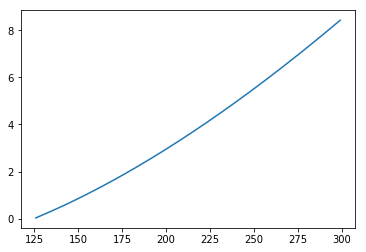

In [113]:
# write a function to calculate the total costs
# from day 1 to day 100, total cost of having capacity more than 125: accountingpenalty=∑d=1001(Nd−125)400Nd(12+|Nd−Nd+1|50)
# draw a line of having those accounting cost based on how many more (from 125 and 300)
# yesterday is 0, then calculate today if yesterday =0, else yesterday = today

# for the first day, diff = 0 , yesterday == today
# first day

#accouting_penalty = (i-125)/400*i**0.5

# i_yesteday_list is null

i_y_list = []
a_p_dict = {}

for i in range(126,300,1):
    #print(i)
    if not i_y_list: 
        diff = 0
        a_p = (i-125)/400*i**(0.5 + diff / 50.0)
        i_y_list.append(i)
        a_p_dict[i] = a_p
        #print('first time')
    
    else:
        a_p = (i-125)/400*i**(0.5 + abs(i-i_y_list[-1])/ 50.0)
        i_y_list.append(i)
        a_p_dict[i] = a_p
        #print('not first time')

#print(a_p_dict)
plt.plot(a_p_dict.keys(), a_p_dict.values())
plt.show()

In [115]:
# take different choices:
# choice 0,1,2,3,4,5...
# each choice has a cost, so we should start with choice 0, fit as many families as we can
# the capacity reaches, then we move to choice 1, then fit as many families as we can
# the capacity reaches again.... 
# also we should consider accounting cost, if we do it at 300 max, then our 
# 5000 families, how many people? 5000/100 50 family a day?

# 21003/100 (everyday we have 210 people , the range is 125-300, hummmm should I keep it at 210 ppl a day?)

210.03